This function uses the up probability defined by as logisitic function as:

$P (X_{t+1} = X_{t} + 1) = \frac{1}{1 + e^{-\alpha_{1}(L-X_{t})}} $

In [2]:
import numpy as np
from dataclasses import dataclass
import itertools

import matplotlib.pyplot as plt

In [3]:
#define Process 1 as a dataclass
@dataclass
class Process1:           
    #define the state as a dataclass with attribute price as an integer
    @dataclass 
    class State:          
        price: int
    
    level_param: int      #level to which price mean-reverts, set explicitly 
    alpha1: float = 0.25  #strength of mean-reversion
    
    #define new function to calculate the up_probability, taking self and state as inputs, where state is of dataclass State
    def up_prob(self, state: State) -> float:
        return 1./ (1+np.exp(-self.alpha1*(self.level_param-state.price)))
    
    #define a new function that determines the next state based on the current state, and outputs the new state as dataclass State
    def next_state(self,state: State) -> State: 
        #draw one sample from a binomial dist with probability up_prob(state), record whether 0 or 1
        up_move: int = np.random.binomial(1,self.up_prob(state),1)[0]
        return Process1.State(price=state.price+up_move*2-1)
    
#Define a simple simulator using Python's generator functionality (i.e., the yield function) It will need a driver function, see next step
def simulation(process, start_state):
    state = start_state #initial state
    #call an infinite loop to go to next state
    while True:
        yield state
        state = process.next_state(state)

#now we generate the traces with a driver function!   
#define a function with inputs of start price, level, alpha1, time_steps desired, and number of traces desired. Output is a multidimensional array
def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int) -> np.ndarray:
    
    process = Process1(level_param=level_param, alpha1=alpha1) #set the process
    start_state = Process1.State(price = start_price) #initialize the start state at the start price as dataclass State
    
    #Create a new 1-dimensional array from an iterable object.
    return np.vstack([                                         
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),time_steps+1)
        ), float)
    for _ in range(num_traces)])

Let's discuss the last piece of code, the return line, from the inside out. At the core we have:

simulation(process, start_state)

which states the iterable function simulation as the object of interest and specifies the process to be used and starting state. Next we have (with * inserted for the above):

s.price for s in itertools.islice(*,time_steps+1)

Here we say that we will iterate the simulation until the stopping point of time_steps + 1. Each iteration of simulation returns a dataclass State, which we call s. s.price is the attribute of s that corresponds to the current price at state s. Next we have:

np.fromiter((*),float)

This takes the iterable "s.price" and converts it into a 1D array with data-type float. Lastly, we have:

np.vstack([ * for _ in range(numtraces)])

This takes the arrays from above and combines them into a matrix where each row is a new simulation trace of prices over the same time-step range. It does this to create numtraces.

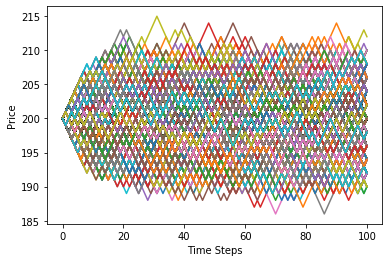

(array([  68.,  224.,  596.,  984., 1235., 1049.,  595.,  176.,   63.,
          10.]),
 array([190. , 192.2, 194.4, 196.6, 198.8, 201. , 203.2, 205.4, 207.6,
        209.8, 212. ]),
 <a list of 10 Patch objects>)

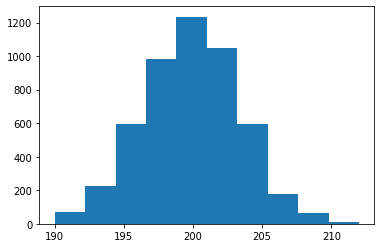

In [5]:
start_price = 200
level_param = 200
alpha1 = 0.1
time_steps = 100
num_traces = 5000

#Run the simulation! Generate the traces!
process1_traces = process1_price_traces(start_price,level_param,alpha1,time_steps,num_traces)

#Plot all of the traces together
for i in range(num_traces):
    plt.plot(process1_traces[i,:])

plt.ylabel('Price')
plt.xlabel('Time Steps')
plt.show()

#plot the distribution of terminal prices
plt.hist(process1_traces[:,-1])